In [430]:
from astropy.table import Table
import numpy as np
from matplotlib import pyplot as plt
import os
%matplotlib inline
from scipy.stats import kstest

In [449]:
#the question...will AMIGA constitute a suitable field population for Virgo WISESize analysis? 

In [325]:
homedir = os.getenv("HOME")

#catalog of AMIGA matched with SGA; includes SGA r50 parameters
cat = Table.read(homedir+'/Desktop/sga_amiga_matched.fits')
#full VF catalog
vf = Table.read(homedir+'/Desktop/v1-20210308/vf_north_v1_main.fits')
#full AMIGA catalog
amiga = Table.read(homedir+'/Downloads/J_A+A_578_A110_table1.dat.fits')
#catalog of AMIGA matched with Hyperleda; 10 arcsecond error
hyp_amiga = Table.read(homedir+'/Downloads/hyp_amiga_matched_10arc')

#sga matched to VF catalog
sgacut = Table.read(homedir+'/sgacut_coadd.fits')
#hyperleda VF catalog
hyp_vf = Table.read(homedir+'/Desktop/v1-20210308/vf_north_v1_hyperleda.fits')
#sga r50 parameters
sga_params = Table.read(homedir+'/sga_params')

In [61]:
#create recession velocity variable, remove 'whiskers' from RA-DEC distribution plot

v = cat['z']*3e5
ra_flag = (cat['RAdeg']>100)&(cat['RAdeg']<300)
cat_racut = cat[ra_flag]

In [129]:
#galaxies that do not appear in SGA

not_sga_flag = []

for i in amiga['SIG']:
    if i not in cat_racut['SIG']:
        not_sga_flag.append(True)
    else:
        not_sga_flag.append(False)

In [130]:
not_in_sga = amiga[not_sga_flag&(amiga['RAdeg']>75)&(amiga['RAdeg']<300)]

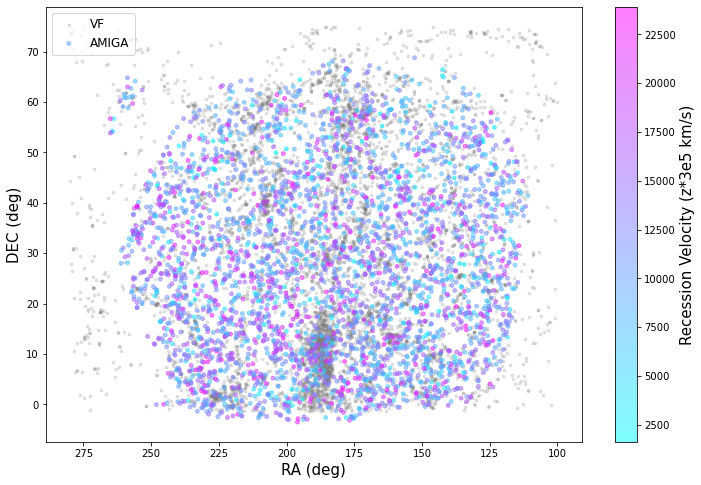

In [141]:
#plot all galaxies within RA bounds (removes outlying whiskers that do not intersect with the region of 
#the sky in which VF lies)

plt.figure(figsize=(12,8))
plt.scatter(vf['RA'],vf['DEC'],color='gray',s=7,alpha=0.2,label="VF")

#optional enclosing of galaxies in AMIGA that do not have SGA counterparts
#plt.scatter(not_in_sga['RAdeg'],not_in_sga['DEdeg'],s=90, facecolors='none', 
#            edgecolors='g',label='AMIGA | SGA')

plt.scatter(cat_racut['RAdeg'],cat_racut['DEdeg'],c=v[ra_flag],cmap='cool',s=15,alpha=0.5,label="AMIGA")

plt.legend(fontsize=12,loc='upper left')

plt.xlabel('RA (deg)',fontsize=15)
plt.ylabel('DEC (deg)',fontsize=15)

ax = plt.gca()
ax.invert_xaxis()

cb = plt.colorbar()
cb.set_label('Recession Velocity (z*3e5 km/s)',fontsize=15)

---

In [ ]:
# plot of D25 vs. redshift for AMIGA sample.
# add a line representing the WISE PSF --> will help determine out to what z we can go and still have AMIGA
# galaxies that are resolvable at WISE wavelengths (indeed...the higher the z, the smaller the galaxy will appear).
# WISE PSF FWHM: 6.5 arcsec.

# logd25 is the decimal logarithm of the length the projected major axis of a galaxy at the isophotal 
# level 25 mag/arcsec2 in the B-band (this is the diameter of the galaxy if it is a disk). 

In [ ]:
#the dimension in arcminutes is 0.1 * 10^(logD25)
#The 0.1 multipler was a convention adopted back in the days of
#printed catalogs to save space and proofreading by avoiding
#negative logs entirely. 

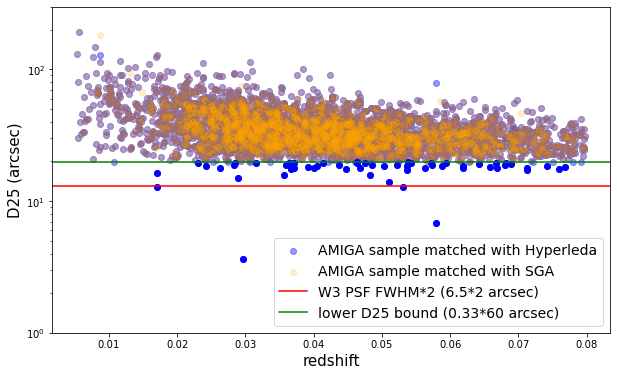

In [343]:
#Hyperleda reports D25 as logD25, in units of 0.1 arcminutes. 
#conversion: 0.1 * 10^(logD25) arcmin
#e.g., a diameter of 10 arcmin will be given as logD25=2.00
#(already set...SGA catalog reports appropriate D25, not logD25)
#converting to arcseconds: multiply by 60


d25 = cat['D25_LEDA']*60     #arcsec
d25_hyp = 0.1 * 10**(hyp_amiga['logd25']) * 60     #arcsec
z = cat['z']
plt.figure(figsize=(10,6))
plt.scatter(hyp_amiga['z'],d25_hyp,label='AMIGA sample matched with Hyperleda',color='blue',alpha=0.4)
plt.scatter(z,d25,label='AMIGA sample matched with SGA',alpha=0.2,color='orange')
plt.yscale('log')

plt.scatter(hyp_amiga['z'][d25_hyp<0.33*60],d25_hyp[d25_hyp<0.33*60],color='blue')

plt.xlabel('redshift',fontsize=15)
plt.ylabel('D25 (arcsec)',fontsize=15)

plt.axhline(6.5*2,label="W3 PSF FWHM*2 (6.5*2 arcsec)",color='red')
plt.axhline(0.33*60,label='lower D25 bound (0.33*60 arcsec)',color='green')
#plt.axhline(180*60,label='upper D25 bound (0.33*60 arcsec)',color='green')

plt.ylim(1,300)
plt.legend(fontsize=14)

In [336]:
counter = 0
for i in hyp_amiga['SIG']:
    if i not in cat['SIG']:
        counter += 1
print('Number of AMIGA galaxies in hyp but not SGA:', counter)
print('Number of AMIGA galaxies in hyp with d25<lower bound:', len(d25_hyp[d25_hyp<(0.33*60)]))

Number of AMIGA galaxies in hyp but not SGA: 178
Number of AMIGA galaxies in hyp with d25<lower bound: 191


-----

In [142]:
#for all AMIGA galaxies with SGA counterparts, calculate r50 (r-band)

r0 = 10 #arcsec
alpha_1 = cat['R_COG_PARAMS_ALPHA1']
alpha_2 = cat['R_COG_PARAMS_ALPHA2']
m0 = cat['R_COG_PARAMS_M0']

comp_one = np.log10(0.5)/(0.4*m0)
comp_two = np.exp(-comp_one) - 1
comp_three = (1/alpha_1) * comp_two
comp_four = comp_three**(-1/alpha_2)

r50 = r0 * comp_four

(1, 300)

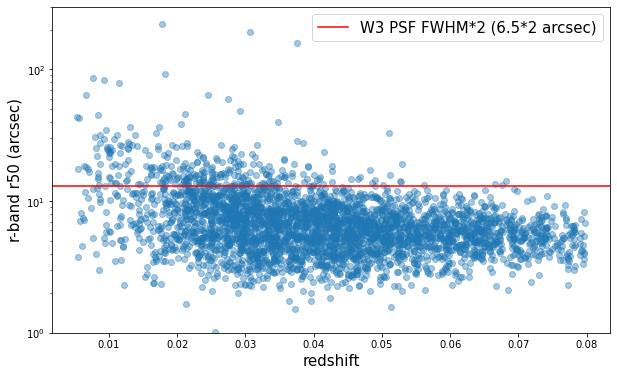

In [176]:
#plot r50 (r-band) vs. redshift
plt.figure(figsize=(10,6))
plt.scatter(z,r50,alpha=0.4)
plt.xlabel('redshift',fontsize=15)
plt.ylabel('r-band r50 (arcsec)',fontsize=15)
plt.yscale('log')
plt.axhline(6.5*2,label="W3 PSF FWHM*2 (6.5*2 arcsec)",color='red')
plt.legend(fontsize=15)
plt.ylim(1,300)

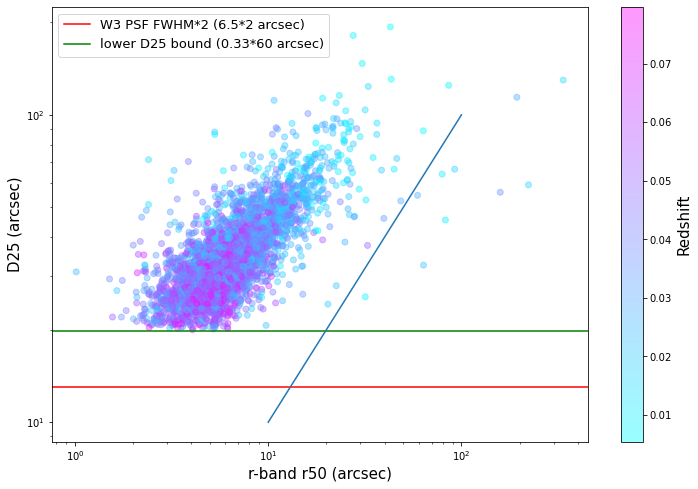

In [173]:
#D25 v. r50 (r-band), with redshift dimension
plt.figure(figsize=(12,8))
plt.scatter(r50,d25,alpha=0.4,c=z,cmap='cool')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('r-band r50 (arcsec)',fontsize=15)
plt.ylabel('D25 (arcsec)',fontsize=15)
plt.axhline(6.5*2,label="W3 PSF FWHM*2 (6.5*2 arcsec)",color='red')
plt.axhline(0.33*60,label='lower D25 bound (0.33*60 arcsec)',color='green')
plt.plot([10,100],[10,100])
plt.legend(fontsize=13)

cb = plt.colorbar()
cb.set_label('Redshift',fontsize=15)

-----

In [ ]:
#for plots of D25 and r50 v. redshift, include the sample VF galaxies (will help visualize how the distribution
#of r50 and D25 correspond between the AMIGA and VF sample.)

In [300]:
hyp_vf_flag = []
for i in hyp_vf['VFID']:
    if i in sgacut['VFID']:
        hyp_vf_flag.append(True)
    else:
        hyp_vf_flag.append(False)

In [301]:
hyp_vf = hyp_vf[hyp_vf_flag]

In [320]:
d25_vf = 0.1 * 10**hyp_vf['logd25'] * 60     #arcsec
z_vf = np.abs(hyp_vf['v'])/3e5     #I am assuming this approach is correct...there are a few REAL nearby galaxies 
                                   #with negative v values

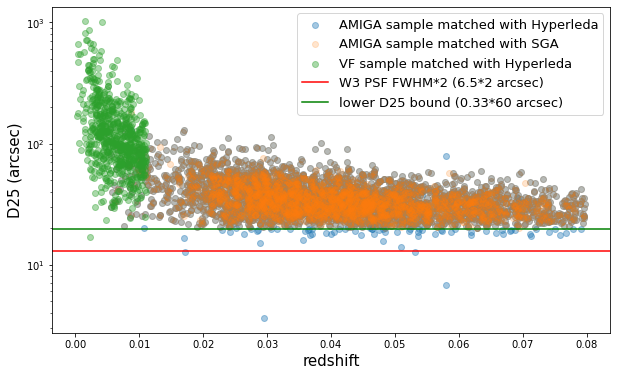

In [323]:
plt.figure(figsize=(10,6))
plt.scatter(hyp_amiga['z'],d25_hyp,label='AMIGA sample matched with Hyperleda',alpha=0.4)
plt.scatter(z,d25,label='AMIGA sample matched with SGA',alpha=0.2)
plt.scatter(z_vf,d25_vf,label='VF sample matched with Hyperleda',alpha=0.4)
plt.yscale('log')

plt.xlabel('redshift',fontsize=15)
plt.ylabel('D25 (arcsec)',fontsize=15)

plt.axhline(6.5*2,label="W3 PSF FWHM*2 (6.5*2 arcsec)",color='red')
plt.axhline(0.33*60,label='lower D25 bound (0.33*60 arcsec)',color='green')
#plt.axhline(180*60,label='upper D25 bound (0.33*60 arcsec)',color='green')

#plt.ylim(1,600)
plt.legend(fontsize=13)

In [330]:
sgaflag=[]

for i in sga_params['name']:
    if i in sgacut['VFID']:
        sgaflag.append(True)
    else:
        sgaflag.append(False)
        
sga_params = sga_params[sgaflag]

In [350]:
#create r50 array; be sure row-matched with hyp_vf table. Theeeen, generate plot of r50 v. redshift, as above.

In [375]:
#for all VFS galaxies with SGA counterparts, calculate r50 (r-band)
r50_vf = []
#check to ascertain that r50 values are in ascending vfid order (i.e., row-matched with sgacut)
vfid_check = []

for i in range(0,len(sgacut)):
    index = np.where(sga_params['VFID'] == sgacut['VFID'][i])
    r0 = 10 #arcsec
    alpha_1 = sga_params['R_COG_PARAMS_ALPHA1'][index]
    alpha_1 = alpha_1.value[0]     #rids alpha_1 of header information
    alpha_2 = sga_params['R_COG_PARAMS_ALPHA2'][index]
    alpha_2 = alpha_2.value[0]     #rids alpha_2 of header information
    m0 = sga_params['R_COG_PARAMS_M0'][index]
    m0 = m0.value[0]     #rids m0 of header information

    comp_one = np.log10(0.5)/(0.4*m0)
    comp_two = np.exp(-comp_one) - 1
    comp_three = (1/alpha_1) * comp_two
    comp_four = comp_three**(-1/alpha_2)

    r50_unmatched = r0 * comp_four
    r50_vf.append(r50_unmatched)
    vfid_check.append(sga_params['VFID'][index].value[0])

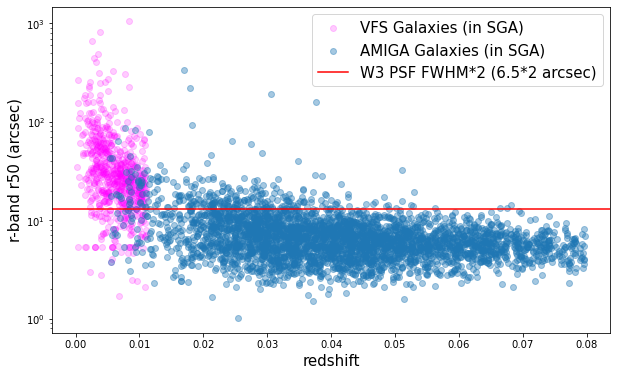

In [439]:
#plot r50 (r-band) vs. redshift
plt.figure(figsize=(10,6))
plt.scatter(z_vf,r50_vf,alpha=0.2,label='VFS Galaxies (in SGA)',color='magenta')
plt.scatter(z,r50,alpha=0.4,label='AMIGA Galaxies (in SGA)')
plt.xlabel('redshift',fontsize=15)
plt.ylabel('r-band r50 (arcsec)',fontsize=15)
plt.yscale('log')
plt.axhline(6.5*2,label="W3 PSF FWHM*2 (6.5*2 arcsec)",color='red')
plt.legend(fontsize=15)
#plt.ylim(1,300)

In [ ]:
#plot histograms of D25 and r50(r) for AMIGA and VFS galaxies at z<0.025.  
#Run a K-S on the distributions to see if the AMIGA and VFS sample have consistent 
#distributions of size for both size measures.

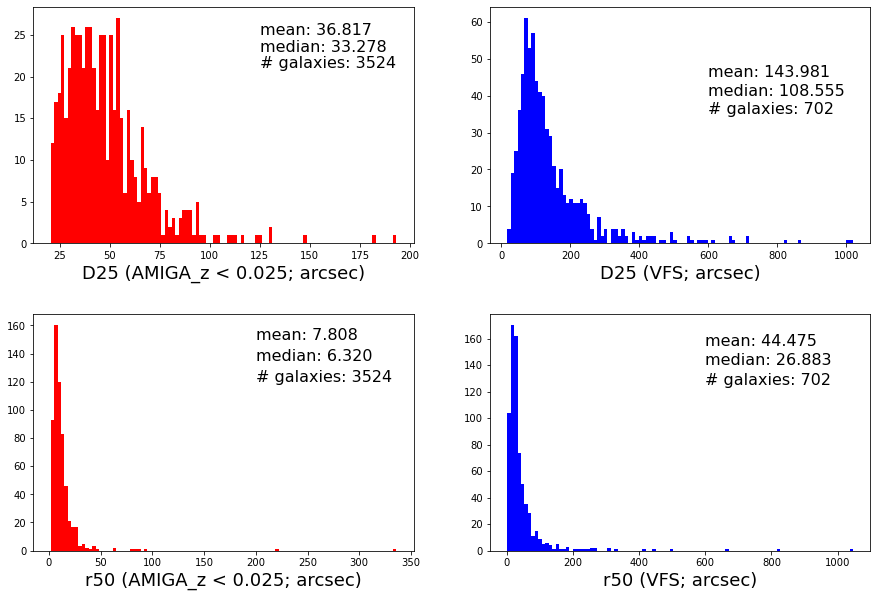

In [418]:
size_bins = [d25[cat['z']<0.025],d25_vf,r50[cat['z']<0.025],r50_vf]     #AMIGA D25, VF D25, AMIGA r50, VF r50
colors = ['red','blue','red','blue']
xlabels = ['D25 (AMIGA_z < 0.025; arcsec)','D25 (VFS; arcsec)','r50 (AMIGA_z < 0.025; arcsec)','r50 (VFS; arcsec)']
xlims = [False,False,False,False]

fig = plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=.3,wspace=.2)

for i in range(1,5):
    ax=fig.add_subplot(2,2,i)
    plt.hist(size_bins[i-1],bins=100,color=colors[i-1])
    plt.xlabel(xlabels[i-1],fontsize=18)
    #plt.xlim(xlims[i-1])

    if i == 1:
        plt.text(125,25,'mean: '+'%.3f'%(np.mean(d25)),fontsize=16)
        plt.text(125,23,'median: '+'%.3f'%(np.median(d25)),fontsize=16)
        plt.text(125,21,'# galaxies: '+str(len(d25)),fontsize=16)        
    if i == 2:
        plt.text(600,45,'mean: '+'%.3f'%(np.mean(d25_vf)),fontsize=16)
        plt.text(600,40,'median: '+'%.3f'%(np.median(d25_vf)),fontsize=16)
        plt.text(600,35,'# galaxies: '+str(len(d25_vf)),fontsize=16) 
    if i == 3:
        plt.text(200,150,'mean: '+'%.3f'%(np.mean(r50)),fontsize=16)
        plt.text(200,135,'median: '+'%.3f'%(np.median(r50)),fontsize=16)
        plt.text(200,120,'# galaxies: '+str(len(r50)),fontsize=16)        
    if i == 4:
        plt.text(600,155,'mean: '+'%.3f'%(np.mean(r50_vf)),fontsize=16)
        plt.text(600,140,'median: '+'%.3f'%(np.median(r50_vf)),fontsize=16)
        plt.text(600,125,'# galaxies: '+str(len(r50_vf)),fontsize=16) 

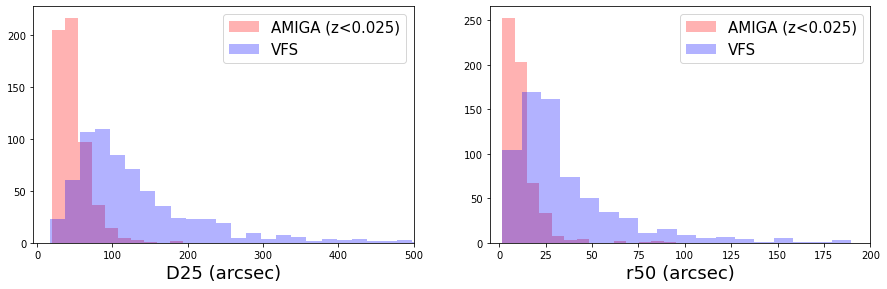

In [434]:
size_bins = [d25[cat['z']<0.025],d25_vf,r50[cat['z']<0.025],r50_vf]     #AMIGA D25, VF D25, AMIGA r50, VF r50
colors = ['red','blue','red','blue']
xlabels = ['D25 (arcsec)','D25 (arcsec)','r50 (arcsec)','r50 (arcsec)']
legend = ['AMIGA (z<0.025)','VFS','AMIGA (z<0.025)','VFS']

fig = plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=.3,wspace=.2)

for i in range(1,3):
    if i == 1:
        ax=fig.add_subplot(2,2,i)
        plt.hist(size_bins[i-1],bins=10,color=colors[i-1],label=legend[i-1],alpha=0.3)
        plt.hist(size_bins[i],bins=50,color=colors[i],label=legend[i],alpha=0.3)
        plt.xlabel(xlabels[i],fontsize=18)
        plt.legend(fontsize=15)
        plt.xlim(-5,500)
    if i == 2:
        ax=fig.add_subplot(2,2,i)
        plt.hist(size_bins[i],bins=50,color=colors[i],label=legend[i],alpha=0.3)
        plt.hist(size_bins[i+1],bins=100,color=colors[i+1],label=legend[i+1],alpha=0.3)
        plt.xlabel(xlabels[i+1],fontsize=18)
        plt.legend(fontsize=15)
        plt.xlim(-5,200)

In [435]:
print('AMIGA vs. VFS (D25):',kstest(d25[cat['z']<0.025],d25_vf))
print('AMIGA vs. VFS (r50):',kstest(r50[cat['z']<0.025],r50_vf))

#"If the p-value of the correlation is less than 0.05, the correlation is statistically significant."

#I think we want low values here..?

AMIGA vs. VFS (D25): KstestResult(statistic=0.672807881773399, pvalue=5.0148562079570395e-137)
AMIGA vs. VFS (r50): KstestResult(statistic=0.5902986540917575, pvalue=2.86396704313737e-103)


In [ ]:
#conclusions:
#could potentially use AMIGA galaxies, and for those with 'smaller' sizes manipulate the FITS scale of cutout
#and PSF to correspond with the comparable galaxies at smaller redshifts from VFS
#however, timescale for Dr. Moustakas to run these galaxies is ~6 months, so not feasible.
#the number of AMIGA field galaxies, moreover, is not considerable relative to that in my VFS subsample.